<a href="https://colab.research.google.com/github/advaitha/NLP/blob/main/tf_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import kaggle

In [11]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [12]:
api = KaggleApi()

In [13]:
api.authenticate()

In [18]:
import zipfile
import os

for file in ['train.tsv','test.tsv']:
  api.competition_download_file('sentiment-analysis-on-movie-reviews', f'{file}.zip', path = './')

  with zipfile.ZipFile(f'{file}.zip','r') as zip_ref:
    zip_ref.extractall('./')

    os.remove(f'{file}.zip')

100%|██████████| 1.28M/1.28M [00:00<00:00, 80.7MB/s]


100%|██████████| 494k/494k [00:00<00:00, 92.3MB/s]

In [19]:
import pandas as pd

In [20]:
df = pd.read_csv('train.tsv', sep = '\t')

In [21]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


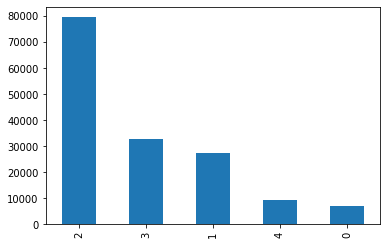

In [22]:
df['Sentiment'].value_counts().plot(kind='bar')

In [23]:
seq_len = 512
num_samples = len(df)
num_samples, seq_len

(156060, 512)

In [25]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [26]:
tokens = tokenizer(df['Phrase'].tolist(),
                   max_length = seq_len, truncation = True,
                   padding = 'max_length', add_special_tokens = True,
                   return_tensors = 'np')

In [27]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [28]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [29]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [32]:
import numpy as np
with open('movie-xids.npy', 'wb') as f:
  np.save(f,tokens['input_ids'])

In [33]:
with open('movie-xmask.npy', 'wb') as f:
  np.save(f,tokens['attention_mask'])

In [34]:
arr = df['Sentiment'].values

In [41]:
arr

array([1, 2, 2, ..., 3, 2, 2])

In [39]:
labels = np.zeros((num_samples, arr.max()+1))

In [40]:
labels.shape

(156060, 5)

In [42]:
labels[np.arange(num_samples),arr] = 1
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [43]:
with open('movie-labels.npy', 'wb') as f:
  np.save(f,labels)

In [44]:
with open('movie-xids.npy','rb') as f:
  Xids = np.load(f,allow_pickle=True)

In [45]:
with open('movie-xmask.npy','rb') as f:
  Xmask = np.load(f, allow_pickle = True)
with open('movie-labels.npy','rb') as f:
  labels = np.load(f,allow_pickle=True)

In [46]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))
dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (5,)), types: (tf.int64, tf.int64, tf.float64)>

In [47]:
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids, 'attention_mask':masks}, labels

In [48]:
dataset = dataset.map(map_func)

In [49]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [50]:
batch_size = 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [51]:
split = 0.9
size = int((Xids.shape[0]/batch_size)*split)
size

8778

In [52]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)
del dataset

In [53]:
tf.data.experimental.save(train_ds,'train')
tf.data.experimental.save(val_ds,'val')

In [54]:
train_ds.element_spec

({'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [55]:
val_ds.element_spec == train_ds.element_spec

True

In [56]:
from transformers import TFAutoModel

In [57]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [58]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [59]:
input_ids = tf.keras.layers.Input(shape=(512,),name='input_ids',
                                  dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name ='attention_mask',
                             dtype='int32')

In [60]:
embeddings = bert.bert(input_ids, attention_mask=mask)[1]
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax',name='outputs')(x)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [61]:
model = tf.keras.Model(inputs=[input_ids,mask],outputs=y)

In [62]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[0][1]                   

In [64]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss = loss, metrics =[acc])

In [65]:
element_spec = ({'input_ids':tf.TensorSpec(shape=(16,512),
                                           dtype = tf.float64, name = None),
                 'attention_mask':tf.TensorSpec(shape=(16,512),
                                                dtype=tf.float64, name=None)},
                tf.TensorSpec(shape=(16,5),dtype=tf.float64,name=None))

In [66]:
train_ds = tf.data.experimental.load('train',element_spec=element_spec)
val_ds = tf.data.experimental.load('val',element_spec=element_spec)

In [67]:
train_ds.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [69]:
history = model.fit(
    train_ds = train_ds,
    validation_data = val_ds,
    epochs = 3
)

TypeError: ignored

In [70]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.float64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)},
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)


In [71]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3


InvalidArgumentError: ignored

In [72]:
model_save('sentiment_model')

NameError: ignored